In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

/home/shreeranga/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/shreeranga/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load and inspect data

In [3]:
# Load data
df = pd.read_csv('conversion_data.csv')
# Preview data
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
# Get info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
# Get more info about the data
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


### Handling age outlier
If we observe the above table, max age is 123 and that is highly unlikely. So, let's get rid of all the observations with age above 95.

In [6]:
df.loc[df['age'] > 95, :]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


So, there are two observations with age > 95. If we remove those then what is the range of remaining ages?

In [7]:
df['age'][df['age'] < 95].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [8]:
print ((df["age"].sort_values(ascending=False)))

90928     123
295581    111
265167     79
192644     77
154217     73
208969     72
114485     70
301366     70
290142     69
57122      69
168374     69
17718      68
262344     68
139000     68
255159     68
209080     68
250056     67
10620      67
216102     67
31654      67
253056     67
10180      66
192772     66
16075      66
139372     66
84466      66
78100      66
197313     66
19067      66
58550      66
         ... 
222398     17
222326     17
222309     17
222307     17
118213     17
222294     17
118226     17
222273     17
222260     17
222249     17
222584     17
8136       17
39235      17
222631     17
39241      17
222829     17
39253      17
39286      17
222747     17
222739     17
118130     17
296893     17
296898     17
222671     17
39337      17
39340      17
90844      17
118149     17
97994      17
229166     17
Name: age, Length: 316200, dtype: int64


In [9]:
df["age"][df["age"] > 79].index

Int64Index([90928, 295581], dtype='int64')

In [10]:
# Remove two rows where age is 123 and 111
df = df.drop(df["age"][df["age"] > 79].index)

In [11]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


Now, we can see from the above table that min age is 17 and max age = 79. This makes a lot of sense.

### Let's inspect country's distribution with conversion rate.

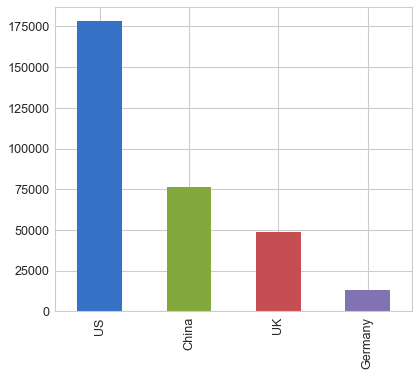

In [12]:
country_dist = df["country"].value_counts()
country_dist.plot(kind="bar")

From the above plot it can be seen that, US has the largest US base and Germany the lowest.

In [13]:
print(df[["country", "converted"]].groupby(["country"], as_index=False).mean())

   country  converted
0    China   0.001332
1  Germany   0.062428
2       UK   0.052612
3       US   0.037801


From the above table it is interesting to see that Germany has the highest conversion rate although user base is low. China lowest with second highest number of users.

### inspect age distribution with conversion

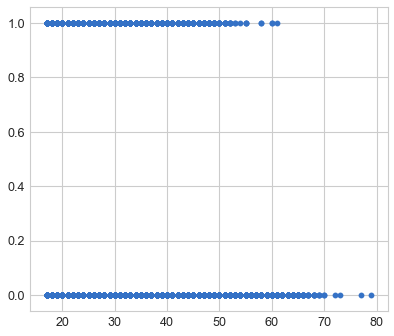

In [14]:
plt.scatter(df["age"], df["converted"])

From the above plot it can be observed that not many people aged > 60 converted.

### Inspect how total pages affected conversion

Text(0.5,1,u'conversion_rates')

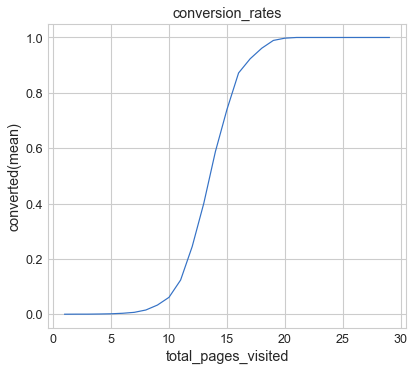

In [15]:
data_pages = df[["total_pages_visited", "converted"]].groupby("total_pages_visited", as_index=False).mean()
plt.plot(data_pages["total_pages_visited"], data_pages["converted"])
plt.xlabel("total_pages_visited")
plt.ylabel("converted(mean)")
plt.title("conversion_rates")

From the above plot, we can conclude that almost all the users who visited more than 20 pages converted.

### Data Preprocessing

Original data has some categorical features such as 'country' and 'source'. Let's do one hot encoding of those features.

In [16]:
X = df.loc[:, ("country", "age", "new_user", "source", "total_pages_visited")]
X = pd.get_dummies(X)

In [17]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [22]:
y = df["converted"]
y.mean()

0.03225194340255157

from y's mean we can conclude that the data is very imbalanced. So, 'accuracy' might not be a very good metric to measure the performance of our model.
It's better to go with ROC analysis.

In [19]:
# Split the data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
y_train.mean(), y_test.mean()

(0.03246134093612522, 0.03182680696912196)

Since y_train and y_test have almost the same mean. We can conclude that there is no bias imported in y_test.

### Model

#### RandomForest Classifier Model

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True, max_features=3, class_weight="balanced")
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

0.96523516417121391

In [34]:
rf_model.score(X_test, y_test)

0.95877177850612383

In [35]:
y_pred = rf_model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_pred)

             precision    recall  f1-score   support

          0       0.99      0.96      0.98    101025
          1       0.42      0.83      0.56      3321

avg / total       0.98      0.96      0.97    104346



In [ ]:
model.feature_importances_

In [ ]:
imp_features = pd.Series(model.feature_importances_, index = X.columns)
imp_features.sort()
imp_features.plot(kind="barh", figsize=(7,6))